In [2]:
import os
import h5py
import librosa
import itertools
from copy import copy
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import os
import librosa
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from scipy.stats import skew

In [3]:
!python --version

Python 3.8.5


In [4]:

import os
import pandas as pd
import ast
import numpy as np

import librosa

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from collections import defaultdict
import pickle

In [5]:
#I took help from github link: https://github.com/celestinhermez/music-genre-classification/blob/master/data_preprocessing/create_audio_features.ipynb
# path to the small directory
SMALL_AUDIO_DIR = 'E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small'

# function to get the paths to all the songs in the small dataset
def audio_paths(AUDIO_DIR):
    AUDIO_PATHS = []
    # iterate through all the directories with songs in them
    for path in [os.path.join('E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small', p) 
                 for p in os.listdir('E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small') 
                 if not (p.endswith('checksums') or p.endswith('.txt') or p.endswith('.DS_Store'))]:
        # add all songs to the list
        AUDIO_PATHS = AUDIO_PATHS + [os.path.join(path, track).replace('\\', '/') for track in os.listdir(path)]
    
    return AUDIO_PATHS

# store all the small paths
SMALL_PATHS = audio_paths(SMALL_AUDIO_DIR)

In [6]:
print(SMALL_PATHS[0:15])

['E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000002.mp3', 'E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000005.mp3', 'E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000010.mp3', 'E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000140.mp3', 'E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000141.mp3', 'E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000148.mp3', 'E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000182.mp3', 'E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000190.mp3', 'E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000193.mp3', 'E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000194.mp3', 'E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000197.mp3', 'E:/8th Semester/CSE4836-Patter

In [7]:
t=pd.read_csv('E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_metadata/tracks.csv')
t.head(3)

C:\Users\HP\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,5,6,8,12,18,20,21,22,24,33,34,38,39,44,47,49) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,album,album.1,album.2,album.3,album.4,album.5,album.6,album.7,album.8,...,track.10,track.11,track.12,track.13,track.14,track.15,track.16,track.17,track.18,track.19
0,NaN,comments,date_created,date_released,engineer,favorites,id,information,listens,producer,...,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
1,track_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food


In [8]:
# function to load metadata
# adapted from https://github.com/mdeff/fma/blob/master/utils.py
def metadata_load(filepath):

    filename = os.path.basename(filepath)

    if 'features' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'echonest' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'genres' in filename:
        return pd.read_csv(filepath, index_col=0)

    if 'tracks' in filename:
        tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

        COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                   ('track', 'genres'), ('track', 'genres_all')]
        for column in COLUMNS:
            tracks[column] = tracks[column].map(ast.literal_eval)

        COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                   ('album', 'date_created'), ('album', 'date_released'),
                   ('artist', 'date_created'), ('artist', 'active_year_begin'),
                   ('artist', 'active_year_end')]
        for column in COLUMNS:
            tracks[column] = pd.to_datetime(tracks[column])

        SUBSETS = ('small', 'medium', 'large')
        try:
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                    pd.CategoricalDtype(categories=SUBSETS, ordered=True))
        except ValueError:
            # the categories and ordered arguments were removed in pandas 0.25
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                     pd.CategoricalDtype(categories=SUBSETS, ordered=True))

        COLUMNS = [('track', 'genre_top'), ('track', 'license'),
                   ('album', 'type'), ('album', 'information'),
                   ('artist', 'bio')]
        for column in COLUMNS:
            tracks[column] = tracks[column].astype('category')

        return tracks

In [9]:
# function to get genre information for each track ID
def track_genre_information(GENRE_PATH, TRACKS_PATH, FILE_PATHS, subset):
    """
    GENRE_PATH (str): path to the csv with the genre metadata
    TRACKS_PATH (str): path to the csv with the track metadata
    FILE_PATHS (list): list of paths to the mp3 files
    subset (str): the subset of the data desired
    """
    # get the genre information
    genres = pd.read_csv(GENRE_PATH)

    # load metadata on all the tracks
    tracks = metadata_load(TRACKS_PATH)
    print(tracks.head(5))

    # focus on the specific subset tracks
    subset_tracks = tracks[tracks['set', 'subset'] <= subset]

    # extract track ID and genre information for each track
    subset_tracks_genre = np.array([np.array(subset_tracks.index), 
                                  np.array(subset_tracks['track', 'genre_top'])]).T
    
    # extract track indices from the file paths
    track_indices = []
    for path in FILE_PATHS:
        track_indices.append(path.split('/')[-1].split('.')[0].lstrip('0'))

    # get the genre associated with each file path, thanks to the path ID
    print(track_indices)
    track_indices = pd.DataFrame({'file_path':FILE_PATHS,'track_id':np.array(track_indices).astype(int)})
    tracks_genre_df = pd.DataFrame({'track_id': subset_tracks_genre[:,0], 'genre': subset_tracks_genre[:,1]})
    track_genre_data = track_indices.merge(tracks_genre_df, how='left')
    
    # label classes with numbers
    encoder = LabelEncoder()
    track_genre_data['genre_nb'] = encoder.fit_transform(track_genre_data.genre)
    
    return track_genre_data

# get genre information for all tracks from the small subset
GENRE_PATH = 'E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_metadata/genres.csv'
TRACKS_PATH = 'E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_metadata/tracks.csv'
subset = 'small'

small_tracks_genre = track_genre_information(GENRE_PATH, TRACKS_PATH, SMALL_PATHS, subset)

            album                                                          \
         comments        date_created date_released engineer favorites id   
track_id                                                                    
2               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
3               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
5               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
10              0 2008-11-26 01:45:08    2008-02-06      NaN         4  6   
20              0 2008-11-26 01:45:05    2009-01-06      NaN         2  4   

                                                                           \
                                        information listens producer tags   
track_id                                                                    
2                                           <p></p>    6073      NaN   []   
3                                           <p></p>    6073      NaN   []  

In [10]:
small_tracks_genre.head(4)

,file_path,track_id,genre,genre_nb
0,E:/8th Semester/CSE4836-Pattern Recognition La...,2,Hip-Hop,3
1,E:/8th Semester/CSE4836-Pattern Recognition La...,5,Hip-Hop,3
2,E:/8th Semester/CSE4836-Pattern Recognition La...,10,Pop,6
3,E:/8th Semester/CSE4836-Pattern Recognition La...,140,Folk,2


# Feature Extraction - 2

In [11]:
#Creating a Dictionary of Genres
genres = {
    'Hip-Hop': 0, 'Pop': 1, 'Folk': 2, 'Experimental': 3, 'Rock': 4, 
    'International': 5, 'Electronic': 6, 'Instrumental': 7
}

In [13]:
directory = 'E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small'

In [14]:
def extract_features(signal, rate, n_fft = 1024, hop_length = 512):

    features = {'spectral_centroid': None, 'spectral_roloff': None, 'spectrul_flux': None, 'root_mse': None,
                'zero_cr': None, 'contrast': None, 'bandwidth': None, 'flatness': None}

    # Using librosa to calculate the features
    features['spectral_centroid'] = librosa.feature.spectral_centroid(signal, sr=rate, n_fft=n_fft, hop_length=hop_length).ravel()
    features['spectral_roloff'] = librosa.feature.spectral_rolloff(signal, sr=rate, n_fft=n_fft, hop_length=hop_length).ravel()
    features['spectrul_flux'] = librosa.onset.onset_strength(y=signal, sr=rate).ravel()
    features['root_mse'] = librosa.feature.rms(signal, frame_length=n_fft, hop_length=hop_length).ravel()
    features['zero_cr'] = librosa.feature.zero_crossing_rate(signal, frame_length=n_fft, hop_length=hop_length).ravel()
    features['contrast'] = librosa.feature.spectral_contrast(signal, sr=rate).ravel()
    features['bandwidth'] = librosa.feature.spectral_bandwidth(signal, sr=rate, n_fft=n_fft, hop_length=hop_length).ravel()
    features['flatness'] = librosa.feature.spectral_flatness(signal, n_fft=n_fft, hop_length=hop_length).ravel()

    # Count silence
    if len(signal) > 0:
        signal_sound, _ = librosa.effects.trim(signal, frame_length=n_fft, hop_length=hop_length)
    features['sample_silence'] = len(signal) - len(signal_sound)
    
    # MFCC treatment
    mfcc = librosa.feature.mfcc(signal, n_fft = n_fft, hop_length = hop_length, n_mfcc=13)
    for i, v_mfcc in enumerate(mfcc):
        features['mfcc_{}'.format(i)] = v_mfcc.ravel()
        
    # Get statistics from the vectors
    def get_moments(base_features):
        extended_features = {}
        for j, v in base_features.items():
            extended_features['{}_max'.format(j)] = np.max(v)
            extended_features['{}_min'.format(j)] = np.min(v)
            extended_features['{}_mean'.format(j)] = np.mean(v)
            extended_features['{}_std'.format(j)] = np.std(v)
            extended_features['{}_kurtosis'.format(j)] = kurtosis(v)
            extended_features['{}_skew'.format(j)] = skew(v)
        return extended_features
    
    final_features = get_moments(features)
    final_features['tempo'] = librosa.beat.tempo(signal, sr=rate)[0]
    
    return final_features

In [17]:
def read_file(dir):
    arr_features = []
    
    for ind in small_tracks_genre.index:
        song_path = small_tracks_genre['file_path'][ind]
        song_genre = small_tracks_genre['genre'][ind]
        
        signal, rate = librosa.load(song_path)
        print("Reading file: {}".format(song_path))
        features = extract_features(signal, rate)
        features['Genre'] = genres[song_genre]
        #print(features)
        arr_features.append(features)
        
    return arr_features

In [18]:
features = read_file(directory)
df_features = pd.DataFrame(features)

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000002.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000005.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000010.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000140.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000141.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000148.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000182.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000190.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000193.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000194.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/001/001427.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/001/001443.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/001/001482.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/001/001510.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/001/001544.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/001/001642.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/001/001644.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/001/001649.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/001/001661.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/001/001663.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/003/003895.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/003/003896.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/003/003904.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/003/003905.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/003/003906.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/003/003908.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/003/003909.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/003/003910.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/003/003911.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/003/003912.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/004/004848.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/004/004849.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/005/005006.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/005/005156.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/005/005157.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/005/005158.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/005/005159.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/005/005169.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/005/005170.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/005/005171.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/006/006788.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/006/006802.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/006/006803.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/006/006854.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/006/006855.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/006/006856.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/006/006857.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/007/007011.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/007/007373.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/007/007374.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/010/010377.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/010/010381.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/010/010382.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/010/010383.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/010/010384.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/010/010385.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/010/010386.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/010/010387.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/010/010388.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/010/010389.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/011/011508.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/011/011544.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/011/011638.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/011/011671.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/011/011672.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/011/011673.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/011/011674.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/011/011675.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/011/011677.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/011/011679.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/012/012067.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/012/012109.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/012/012146.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/012/012147.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/012/012173.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/012/012174.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/012/012179.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/012/012188.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/012/012189.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/012/012346.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/013/013747.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/013/013748.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/013/013749.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/013/013767.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/013/013768.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/013/013804.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/013/013927.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/013/013928.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/013/013929.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/013/013930.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/015/015543.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/015/015625.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/015/015769.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/015/015770.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/015/015771.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/015/015772.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/015/015773.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/015/015880.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/016/016095.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/016/016155.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/018/018877.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/018/018887.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/019/019073.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/019/019074.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/019/019179.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/019/019184.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/019/019187.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/019/019192.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/019/019412.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/019/019413.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/021/021996.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/021/021997.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/021/021998.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/021/021999.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/022/022000.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/022/022001.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/022/022088.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/022/022091.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/022/022093.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/022/022094.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/024/024720.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/024/024739.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/024/024741.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/024/024742.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/024/024745.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/024/024746.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/024/024747.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/024/024748.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/024/024749.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/024/024842.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/026/026629.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/026/026638.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/026/026639.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/026/026640.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/026/026641.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/026/026642.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/026/026643.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/026/026651.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/026/026652.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/026/026653.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/028/028485.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/028/028546.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/028/028548.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/028/028553.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/028/028571.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/028/028608.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/028/028692.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/028/028802.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/029/029037.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/029/029039.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/031/031043.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/031/031044.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/031/031165.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/031/031356.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/031/031389.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/031/031390.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/031/031391.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/031/031392.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/031/031568.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/031/031807.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/034/034147.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/034/034167.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/034/034257.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/034/034258.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/034/034263.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/034/034484.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/034/034510.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/034/034511.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/034/034994.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/034/034996.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/036/036990.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/036/036992.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/036/036994.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/036/036997.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/036/036998.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/036/036999.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/037/037041.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/037/037111.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/037/037113.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/037/037119.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/038/038880.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/038/038881.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/038/038882.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/038/038884.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/038/038886.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/038/038887.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/038/038888.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/038/038890.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/038/038891.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/038/038892.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/040/040238.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/040/040239.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/040/040240.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/040/040241.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/040/040242.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/040/040243.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/040/040244.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/040/040245.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/040/040250.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/040/040509.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/042/042141.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/042/042146.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/042/042234.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/042/042235.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/042/042236.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/042/042238.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/042/042240.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/042/042241.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/042/042243.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/042/042245.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/043/043761.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/043/043765.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/043/043766.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/043/043767.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/043/043768.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/043/043773.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/043/043796.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/043/043842.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/043/043843.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/043/043844.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/045/045103.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/045/045119.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/045/045122.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/045/045125.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/045/045126.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/045/045127.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/045/045128.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/045/045149.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/045/045150.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/045/045151.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/047/047192.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/047/047193.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/047/047194.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/047/047195.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/047/047196.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/047/047197.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/047/047198.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/047/047199.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/047/047200.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/047/047201.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/048/048931.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/048/048990.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/048/048999.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/049/049029.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/049/049030.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/049/049039.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/049/049061.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/049/049062.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/049/049064.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/049/049066.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/051/051274.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/051/051275.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/051/051276.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/051/051278.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/051/051291.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/051/051292.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/051/051301.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/051/051305.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/051/051333.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/051/051479.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/052/052647.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/052/052648.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/052/052649.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/052/052650.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/052/052859.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/052/052860.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/052/052861.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/052/052862.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/052/052945.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/052/052946.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/054/054365.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/054/054376.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/054/054433.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/054/054436.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/054/054437.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/054/054438.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/054/054442.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/054/054443.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/054/054463.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/054/054464.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/055/055430.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/055/055436.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/055/055437.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/055/055480.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/055/055481.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/055/055549.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/055/055572.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/055/055709.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/055/055710.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/055/055711.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/056/056651.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/056/056686.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/056/056687.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/056/056688.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/056/056689.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/056/056690.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/056/056691.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/056/056692.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/056/056693.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/056/056694.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/058/058060.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/058/058061.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/058/058063.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/058/058068.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/058/058070.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/058/058115.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/058/058116.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/058/058117.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/058/058135.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/058/058140.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/059/059719.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/059/059720.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/059/059721.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/059/059723.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/059/059724.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/059/059725.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/059/059726.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/059/059727.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/059/059823.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/059/059876.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/061/061679.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/061/061734.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/061/061736.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/061/061742.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/061/061814.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/061/061820.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/061/061821.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/061/061884.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/062/062001.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/062/062003.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/063/063258.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/063/063287.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/063/063289.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/063/063290.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/063/063291.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/063/063292.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/063/063456.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/063/063457.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/063/063470.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/063/063471.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/064/064629.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/064/064630.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/064/064631.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/064/064659.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/064/064787.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/064/064788.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/064/064789.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/064/064796.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/064/064809.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/064/064834.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/066/066637.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/066/066638.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/066/066641.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/066/066643.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/066/066644.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/066/066646.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/066/066648.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/066/066649.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/066/066650.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/066/066689.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/068/068538.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/068/068539.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/068/068540.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/068/068541.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/068/068543.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/068/068549.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/068/068551.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/068/068573.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/068/068579.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/068/068582.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/069/069723.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/069/069726.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/069/069727.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/069/069732.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/069/069744.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/069/069745.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/069/069746.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/069/069747.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/069/069761.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/069/069762.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/071/071230.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/071/071231.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/071/071240.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/071/071241.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/071/071242.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/071/071243.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/071/071244.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/071/071245.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/071/071246.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/071/071247.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/072/072206.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/072/072210.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/072/072215.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/072/072232.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/072/072233.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/072/072234.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/072/072287.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/072/072288.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/072/072289.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/072/072290.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/073/073551.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/073/073560.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/073/073561.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/073/073564.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/073/073565.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/073/073566.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/073/073568.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/073/073572.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/073/073573.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/073/073580.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/074/074959.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/074/074960.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/075/075194.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/075/075211.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/075/075221.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/075/075230.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/075/075304.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/075/075310.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/075/075314.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/075/075317.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/075/075869.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/075/075883.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/075/075903.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/075/075908.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/075/075925.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/075/075926.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/075/075927.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/075/075928.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/075/075929.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/075/075930.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/079/079995.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/080/080000.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/080/080001.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/080/080002.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/080/080003.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/080/080004.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/080/080005.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/080/080035.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/080/080293.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/080/080341.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/081/081814.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/081/081868.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/081/081895.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/081/081938.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/081/081945.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/081/081946.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/081/081988.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/081/081999.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/082/082157.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/082/082231.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/084/084139.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/084/084141.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/084/084142.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/084/084144.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/084/084152.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/084/084154.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/084/084155.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/084/084156.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/084/084157.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/084/084158.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/085/085691.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/085/085692.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/085/085693.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/085/085787.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/085/085788.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/085/085791.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/085/085792.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/085/085816.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/085/085817.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/085/085822.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/086/086993.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/087/087068.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/087/087069.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/087/087070.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/087/087096.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/087/087097.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/087/087098.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/087/087099.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/087/087100.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/087/087101.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/088/088875.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/088/088876.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/088/088877.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/088/088878.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/088/088879.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/088/088892.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/088/088899.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/088/088900.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/088/088959.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/088/088960.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/091/091089.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/091/091092.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/091/091093.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/091/091098.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/091/091102.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/091/091130.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/091/091157.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/091/091158.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/091/091159.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/091/091160.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/092/092466.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/092/092508.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/092/092535.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/092/092536.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/092/092538.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/092/092539.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/092/092540.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/092/092546.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/092/092548.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/092/092549.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/094/094099.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/094/094101.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/094/094102.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/094/094263.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/094/094348.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/094/094411.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/094/094414.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/094/094415.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/094/094419.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/094/094422.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/096/096900.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/096/096901.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/096/096902.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/096/096935.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/096/096936.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/096/096944.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/096/096945.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/096/096946.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/097/097037.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/097/097041.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/098/098237.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/098/098238.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/098/098251.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/098/098297.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/098/098298.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/098/098299.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/098/098300.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/098/098301.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/098/098302.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/098/098339.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/099/099368.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/099/099369.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/099/099370.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/099/099371.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/099/099372.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/099/099373.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/099/099374.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/099/099375.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/099/099389.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/099/099390.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/104/104086.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/104/104227.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/104/104276.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/104/104277.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/104/104278.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/104/104279.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/104/104282.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/104/104283.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/104/104284.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/104/104356.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/106/106567.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/106/106568.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/106/106569.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/106/106570.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/106/106571.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/106/106629.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/106/106872.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/106/106876.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/106/106877.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/106/106937.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/107/107589.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/107/107590.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/107/107591.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/107/107592.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/107/107593.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/107/107594.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/107/107595.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/107/107596.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/107/107597.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/107/107598.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/108/108343.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/108/108415.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/108/108416.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/108/108418.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/108/108420.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/108/108421.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/108/108422.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/108/108423.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/108/108425.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/108/108426.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/108/108882.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/108/108883.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/108/108884.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/108/108885.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/108/108906.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/108/108957.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/108/108961.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/108/108962.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/108/108967.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/108/108968.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/110/110106.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/110/110107.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/110/110108.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/110/110109.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/110/110110.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/110/110111.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/110/110166.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/110/110167.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/110/110171.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/110/110172.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/110/110923.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/110/110927.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/110/110928.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/110/110980.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/110/110982.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/110/110983.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/110/110985.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/111/111015.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/111/111146.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/111/111147.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/111/111994.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/112/112000.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/112/112001.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/112/112020.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/112/112065.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/112/112066.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/112/112088.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/112/112133.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/112/112196.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/112/112197.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/113/113164.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/113/113165.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/113/113166.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/113/113167.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/113/113203.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/113/113259.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/113/113260.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/113/113261.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/113/113262.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/113/113263.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/114/114040.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/114/114041.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/114/114042.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/114/114044.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/114/114045.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/114/114047.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/114/114048.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/114/114049.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/114/114050.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/114/114051.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/114/114402.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/114/114403.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/114/114404.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/114/114405.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/114/114406.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/114/114408.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/114/114409.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/114/114410.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/114/114411.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/114/114412.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/115/115764.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/115/115765.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/115/115766.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/115/115767.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/115/115768.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/115/115769.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/115/115771.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/115/115772.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/115/115773.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/115/115774.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/116/116491.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/116/116514.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/116/116517.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/116/116525.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/116/116526.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/116/116527.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/116/116528.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/116/116547.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/116/116549.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/116/116586.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/117/117943.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/117/117944.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/117/117945.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/117/117946.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/117/117961.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/117/117966.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/117/117967.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/117/117970.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/117/117991.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/118/118000.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/119/119193.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/119/119257.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/119/119369.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/119/119379.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/119/119413.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/119/119545.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/119/119569.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/119/119571.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/119/119574.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/119/119575.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/120/120306.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/120/120307.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/120/120308.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/120/120309.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/120/120310.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/120/120312.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/120/120313.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/120/120314.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/120/120315.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/120/120316.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/121/121590.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/121/121591.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/121/121592.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/121/121593.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/121/121594.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/121/121595.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/121/121651.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/121/121652.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/121/121653.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/121/121654.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/122/122364.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/122/122365.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/122/122395.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/122/122397.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/122/122398.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/122/122399.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/122/122400.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/122/122456.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/122/122457.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/122/122472.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/123/123099.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/123/123147.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/123/123273.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/123/123278.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/123/123333.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/123/123342.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/123/123427.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/123/123438.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/123/123439.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/123/123440.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/124/124183.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/124/124184.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/124/124185.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/124/124186.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/124/124201.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/124/124231.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/124/124391.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/124/124392.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/124/124393.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/124/124394.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/125/125238.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/125/125239.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/125/125240.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/125/125286.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/125/125287.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/125/125288.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/125/125289.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/125/125291.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/125/125293.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/125/125298.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/126/126218.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/126/126219.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/126/126220.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/126/126221.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/126/126223.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/126/126224.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/126/126225.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/126/126226.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/126/126227.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/126/126229.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/126/126585.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/126/126586.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/126/126587.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/126/126588.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/126/126589.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/126/126598.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/126/126600.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/126/126601.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/126/126602.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/126/126603.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/127/127212.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/127/127263.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/127/127265.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/127/127266.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/127/127267.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/127/127268.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/127/127269.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/127/127271.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/127/127273.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/127/127274.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/127/127910.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/127/127911.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/127/127912.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/127/127913.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/127/127914.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/127/127915.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/127/127916.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/127/127936.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/127/127996.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/128/128441.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/129/129185.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/129/129186.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/129/129187.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/129/129188.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/129/129189.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/129/129190.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/129/129268.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/129/129362.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/129/129372.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/129/129374.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/130/130134.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/130/130135.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/130/130136.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/130/130137.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/130/130168.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/130/130170.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/130/130218.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/130/130265.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/130/130347.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/130/130349.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/131/131439.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/131/131444.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/131/131446.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/131/131448.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/131/131449.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/131/131451.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/131/131452.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/131/131453.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/131/131454.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/131/131476.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/132/132122.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/132/132134.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/132/132138.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/132/132139.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/132/132140.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/132/132141.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/132/132142.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/132/132171.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/132/132272.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/132/132310.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/133/133438.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/133/133439.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/133/133440.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/133/133441.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/133/133442.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/133/133443.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/133/133444.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/133/133445.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/133/133446.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/133/133447.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/134/134077.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/134/134084.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/134/134094.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/134/134359.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/134/134384.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/134/134385.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/134/134388.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/134/134389.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/134/134443.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/134/134444.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/135/135220.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/135/135221.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/135/135222.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/135/135223.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/135/135224.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/135/135225.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/135/135226.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/135/135227.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/135/135228.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/135/135229.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/137/137423.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/137/137424.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/137/137425.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/137/137426.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/137/137462.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/137/137463.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/137/137484.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/137/137500.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/137/137551.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/137/137561.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/138/138317.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/138/138318.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/138/138319.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/138/138320.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/138/138351.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/138/138355.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/138/138406.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/138/138410.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/138/138413.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/138/138414.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/140/140576.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/140/140583.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/140/140584.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/140/140609.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/140/140620.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/140/140621.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/140/140623.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/140/140625.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/140/140626.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/140/140788.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/141/141874.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/141/141875.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/141/141876.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/141/141877.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/141/141878.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/141/141894.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/141/141901.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/141/141902.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/141/141903.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/141/141972.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/142/142670.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/142/142671.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/142/142672.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/142/142947.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/142/142948.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/142/142949.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/142/142950.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/143/143039.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/143/143046.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/143/143055.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/144/144544.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/144/144545.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/144/144546.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/144/144547.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/144/144548.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/144/144549.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/144/144550.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/144/144551.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/144/144552.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/144/144587.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/145/145706.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/145/145707.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/145/145708.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/145/145709.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/145/145710.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/145/145711.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/145/145724.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/145/145727.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/145/145728.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/145/145729.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/147/147087.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/147/147126.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/147/147191.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/147/147261.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/147/147265.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/147/147267.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/147/147268.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/147/147269.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/147/147295.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/147/147309.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/148/148535.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/148/148536.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/148/148537.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/148/148584.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/148/148585.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/148/148586.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/148/148587.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/148/148602.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/148/148603.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/148/148604.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/152/152253.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/152/152254.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/152/152258.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/152/152261.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/152/152262.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/152/152324.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/152/152418.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/152/152425.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/152/152480.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/152/152543.mp3
Reading fi

In [19]:
df_features.head(10)

,spectral_centroid_max,spectral_centroid_min,spectral_centroid_mean,spectral_centroid_std,spectral_centroid_kurtosis,spectral_centroid_skew,spectral_roloff_max,spectral_roloff_min,spectral_roloff_mean,spectral_roloff_std,...,mfcc_11_kurtosis,mfcc_11_skew,mfcc_12_max,mfcc_12_min,mfcc_12_mean,mfcc_12_std,mfcc_12_kurtosis,mfcc_12_skew,tempo,Genre
0,6830.249231,774.102364,2953.995346,1026.351341,1.396197,1.215301,9840.673828,1356.591797,6021.724393,1609.475407,...,-0.039417,0.224601,28.494658,-35.534214,-3.077930,9.801686,0.170572,-0.180527,161.499023,0
1,5649.069002,698.367916,2329.471181,921.025280,0.645469,0.868937,9862.207031,1119.726562,5218.579271,1765.688566,...,0.554058,-0.022098,43.819607,-25.671841,4.246510,10.355387,0.070514,0.223105,99.384014,0
2,4210.524039,1351.311356,2284.701111,377.365163,2.853570,1.218936,8010.351562,2950.048828,4206.864001,828.076166,...,-0.032181,0.084442,14.155300,-30.068916,-6.703146,6.913006,0.149681,0.034437,112.347147,1
3,6028.143902,0.000000,1556.653764,1004.935450,4.198145,1.919153,9689.941406,0.000000,3271.145415,2420.010275,...,0.234660,0.007511,16.390335,-39.605667,-7.226449,9.067884,0.076576,-0.201192,107.666016,2
4,6255.048660,0.000000,1531.768654,789.462750,8.976394,2.323244,9474.609375,0.000000,3043.437213,1652.338004,...,0.336328,-0.691935,21.727013,-31.612373,-4.410470,8.300075,0.162507,-0.325025,117.453835,2
5,3296.574331,422.117437,1658.369761,543.337937,-0.418084,0.043866,7472.021484,689.062500,3465.361230,1497.778694,...,0.694319,0.483308,26.549995,-32.669891,-0.031027,8.136060,0.537237,0.224818,117.453835,3
6,2983.158587,920.442636,1804.696748,370.095332,-0.212660,0.447647,5512.500000,1593.457031,3806.364197,865.478822,...,-0.028826,-0.067434,41.757076,-22.012510,3.353926,7.539043,1.334834,0.263921,143.554688,4
7,5988.348851,998.450836,1794.895242,669.051546,13.456275,3.248599,9453.076172,1571.923828,3494.940455,1263.238566,...,0.055523,-0.042821,18.694714,-43.980118,-9.601484,10.539456,-0.330620,0.031014,103.359375,2
8,6063.489254,870.858421,1522.823454,592.960061,10.189299,2.599038,8979.345703,1205.859375,3066.705081,1240.058199,...,1.335690,0.370233,13.120387,-34.128323,-8.083507,8.289574,-0.216635,-0.390230,95.703125,2
9,4208.494365,872.922174,1479.139395,456.236783,9.230817,2.416083,8161.083984,1528.857422,2935.959818,1031.060757,...,0.557774,0.016257,18.531456,-31.559303,-8.895642,7.202939,0.518820,0.214301,103.359375,2


In [20]:
df_features.to_csv('datafile - 2.csv')

In [21]:
df_features.shape

(7997, 134)

# Decision Tree

In [1]:
!python --version
import tensorflow as tf
print("Num GPUs Available", len(tf.config.experimental.list_physical_devices('GPU')))

Python 3.8.5
Num GPUs Available 1


In [5]:
# Imports needed for the script
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

In [3]:
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
import lightgbm as lgbm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [6]:
datafile_tree = pd.read_csv('datafile - 2.csv')
train_tree, test_tree = train_test_split(datafile_tree, test_size=0.20)
train_tree.shape,test_tree.shape

((6397, 135), (1600, 135))

In [7]:
X_train = train_tree.drop(['Genre'], axis=1).values
y_train = train_tree['Genre'].values
X_test = test_tree.drop(['Genre'], axis=1).values
y_test = test_tree['Genre'].values

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMClassifier

In [9]:
parameters = {
    "classifier__criterion": ["entropy", "gini"],
    "classifier__splitter": ["random", "best"],
}

pipeline_tree = Pipeline([
    ('var_tresh', VarianceThreshold(threshold=.16)),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('classifier', DecisionTreeClassifier())
])

grid_tree = GridSearchCV(pipeline_tree, parameters, scoring='accuracy', n_jobs=6, cv=5)
grid_tree.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('var_tresh',
                                        VarianceThreshold(threshold=0.16)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('classifier',
                                        DecisionTreeClassifier())]),
             n_jobs=6,
             param_grid={'classifier__criterion': ['entropy', 'gini'],
                         'classifier__splitter': ['random', 'best']},
             scoring='accuracy')

In [10]:
print("Best Parameters = ",grid_tree.best_params_)
print("Accuracy over Train set = ",grid_tree.best_score_)
y_pred = grid_tree.predict(X_test)
print("Accuracy over Test set = ",accuracy_score(y_test, y_pred))

Best Parameters =  {'classifier__criterion': 'entropy', 'classifier__splitter': 'best'}
Accuracy over Train set =  0.37313868256450344
Accuracy over Test set =  0.395


In [11]:
import joblib
joblib.dump(grid_tree.best_params_, 'grid_tree_2.pkl', compress = 1)
grid_tree_1_params = joblib.load('grid_tree_2.pkl')
print(grid_tree_1_params)

{'classifier__criterion': 'entropy', 'classifier__splitter': 'best'}


In [13]:
#Variance Thresholding 
var_thres = VarianceThreshold(threshold=(.8 * (1 - .8)))
thres_X = var_thres.fit_transform(X_train)

#Feature Selection
lgb = lgbm.LGBMClassifier(C=0.01, penalty="l1", dual=False).fit(thres_X, y_train)
feat_selection = SelectFromModel(lgb, prefit=True)
X_train = feat_selection.transform(thres_X)

In [14]:
thres_X = var_thres.fit_transform(X_test)
X_test = feat_selection.transform(thres_X)

In [15]:
decision_tree_clf = DecisionTreeClassifier(criterion='entropy',splitter='best')
decision_tree_clf.fit(X_train,y_train)
y_pred = decision_tree_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.395625

In [16]:
target_names = ['Hip-Hop', 'Pop', 'Folk', 'Experimental','Rock','International','Electronic','Instrumental']

In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=target_names))

               precision    recall  f1-score   support

      Hip-Hop       0.47      0.46      0.47       207
          Pop       0.23      0.26      0.24       201
         Folk       0.49      0.44      0.47       207
 Experimental       0.29      0.31      0.30       180
         Rock       0.41      0.38      0.39       184
International       0.44      0.38      0.41       228
   Electronic       0.37      0.41      0.39       202
 Instrumental       0.48      0.51      0.49       191

     accuracy                           0.40      1600
    macro avg       0.40      0.39      0.40      1600
 weighted avg       0.40      0.40      0.40      1600



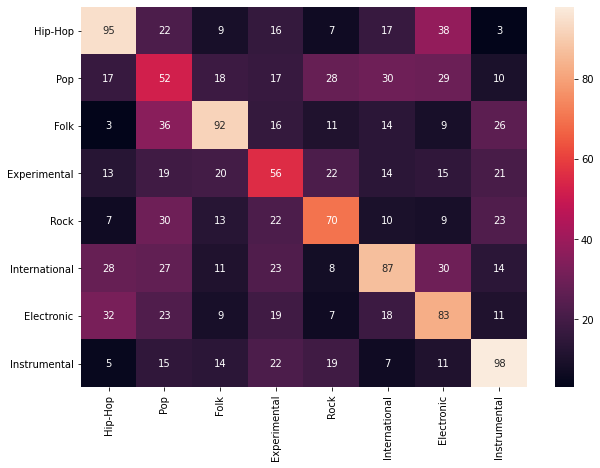

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
confusion_matrix=confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(confusion_matrix, index = [i for i in target_names],
                  columns = [i for i in target_names])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

# KNN- Algorithm

In [19]:
#Load the necessary python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
#importing train_test_split
from sklearn.model_selection import train_test_split

In [20]:
datafile_knn = pd.read_csv('datafile - 2.csv')
train_knn, test_knn = train_test_split(datafile_knn, test_size=0.20)
train_knn.shape,test_knn.shape

((6397, 135), (1600, 135))

In [21]:
X_train = train_knn.drop(['Genre'], axis=1).values
y_train = train_knn['Genre'].values
X_test = test_knn.drop(['Genre'], axis=1).values
y_test = test_knn['Genre'].values

In [22]:
#import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

#Setup arrays to store training and test accuracies
neighbors = np.arange(1,9)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    #Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    
    #Fit the model
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)
    
    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, y_test) 

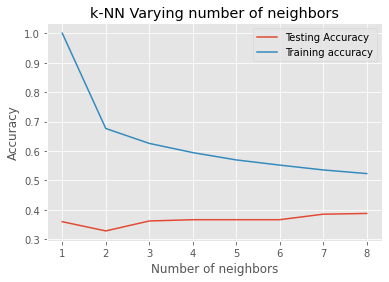

In [23]:
#Generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

In [24]:
#Setup a knn classifier with k neighbors
knn = KNeighborsClassifier(n_neighbors=8)
#Fit the model
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=8)

In [25]:
knn.score(X_test,y_test)

0.3875

In [26]:
k_range = list(range(1,31))
weight_options = ["uniform", "distance"]

param_grid = dict(n_neighbors = k_range, weights = weight_options)

knn = KNeighborsClassifier()

grid_knn = GridSearchCV(knn, param_grid, cv = 10, scoring = 'accuracy')
grid_knn.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [27]:
print("Best Parameters = ",grid_knn.best_params_)
print("Accuracy over Train set = ",grid_knn.best_score_)
y_pred = grid_knn.predict(X_test)
print("Accuracy over Test set = ",accuracy_score(y_test, y_pred))

Best Parameters =  {'n_neighbors': 15, 'weights': 'distance'}
Accuracy over Train set =  0.4122278462441315
Accuracy over Test set =  0.406875


In [28]:
import joblib
joblib.dump(grid_knn.best_params_, 'grid_knn_2.pkl', compress = 1)
grid_knn_1_params = joblib.load('grid_knn_2.pkl')
print(grid_knn_1_params)

{'n_neighbors': 15, 'weights': 'distance'}


In [29]:
knn_clf = KNeighborsClassifier(n_neighbors= 15, weights= 'distance')
knn_clf.fit(X_train,y_train)
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.406875

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=target_names))

               precision    recall  f1-score   support

      Hip-Hop       0.35      0.52      0.42       172
          Pop       0.29      0.21      0.25       202
         Folk       0.44      0.58      0.50       200
 Experimental       0.32      0.17      0.22       192
         Rock       0.42      0.42      0.42       213
International       0.38      0.38      0.38       208
   Electronic       0.43      0.33      0.38       211
 Instrumental       0.52      0.65      0.58       202

     accuracy                           0.41      1600
    macro avg       0.40      0.41      0.39      1600
 weighted avg       0.40      0.41      0.39      1600



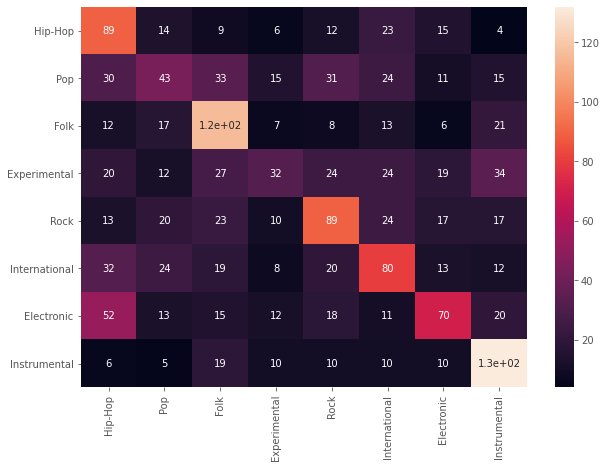

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
confusion_matrix=confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(confusion_matrix, index = [i for i in target_names],
                  columns = [i for i in target_names])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

# Support Vector Machine

In [21]:
import pandas as pd 
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn import svm

import itertools

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import seaborn

%matplotlib inline

In [22]:
datafile_svm = pd.read_csv('datafile - 2.csv')
train_svm, test_svm = train_test_split(datafile_svm, test_size=0.20)
train_svm.shape,test_svm.shape

((6397, 135), (1600, 135))

In [23]:
X_train = train_svm.drop(['Genre'], axis=1).values
y_train = train_svm['Genre'].values
X_test = test_svm.drop(['Genre'], axis=1).values
y_test = test_svm['Genre'].values

In [24]:
print(X_train.shape, X_test.shape)

(6397, 134) (1600, 134)


In [27]:
#Here I will tune hyperparameter for linear,sigmoid and poly
parameters = {
    "clf__C": [0.5, 1, 2, 5],
    "clf__kernel": ['poly', 'linear', 'sigmoid'],  #did rbf in separate block as to avoid gamma calculation for these three
}

pipeline_svm = Pipeline([
    ('scaling', StandardScaler()),
    ('var_tresh', VarianceThreshold(threshold=.16)),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('clf', SVC())
])

grid_svm = GridSearchCV(pipeline_svm, parameters, scoring='accuracy', n_jobs=6, cv=5)
grid_svm.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaling', StandardScaler()),
                                       ('var_tresh',
                                        VarianceThreshold(threshold=0.16)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('clf', SVC())]),
             n_jobs=6,
             param_grid={'clf__C': [0.5, 1, 2, 5],
                         'clf__kernel': ['poly', 'linear', 'sigmoid']},
             scoring='accuracy')

In [28]:
print("Best Parameters = ",grid_svm.best_params_)
print("Accuracy over Train set = ",grid_svm.best_score_)
y_pred = grid_svm.predict(X_test)
print("Accuracy over Test set = ",accuracy_score(y_test, y_pred))

Best Parameters =  {'clf__C': 0.5, 'clf__kernel': 'linear'}
Accuracy over Train set =  0.5260236268569194
Accuracy over Test set =  0.51875


In [29]:
parameters = {
    "clf__C": [0.5, 1, 2, 5],
    "clf__gamma": [1, 0.1, 0.01,0.001],
    "clf__kernel": ['rbf'],  #did 'rbf' separately here
}

pipeline_svm_rbf = Pipeline([
    ('scaling', StandardScaler()),
    ('var_tresh', VarianceThreshold(threshold=.16)),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('clf', SVC())
])

grid_svm_rbf = GridSearchCV(pipeline_svm, parameters, scoring='accuracy', n_jobs=6, cv=5)
grid_svm_rbf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaling', StandardScaler()),
                                       ('var_tresh',
                                        VarianceThreshold(threshold=0.16)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('clf', SVC())]),
             n_jobs=6,
             param_grid={'clf__C': [0.5, 1, 2, 5],
                         'clf__gamma': [1, 0.1, 0.01, 0.001],
                         'clf__kernel': ['rbf']},
             scoring='accuracy')

In [30]:
print("Best Parameters = ",grid_svm_rbf.best_params_)
print("Accuracy over Train set = ",grid_svm_rbf.best_score_)
y_pred = grid_svm_rbf.predict(X_test)
print("Accuracy over Test set = ",accuracy_score(y_test, y_pred))

Best Parameters =  {'clf__C': 5, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}
Accuracy over Train set =  0.5657315285379203
Accuracy over Test set =  0.56


In [31]:
import joblib
joblib.dump(grid_svm_rbf.best_params_, 'grid_svm_2.pkl', compress = 1)
grid_svm_1_params = joblib.load('grid_svm_2.pkl')
print(grid_svm_1_params)

{'clf__C': 5, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}


In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=target_names))

               precision    recall  f1-score   support

      Hip-Hop       0.67      0.68      0.67       203
          Pop       0.43      0.34      0.38       222
         Folk       0.57      0.63      0.60       200
 Experimental       0.51      0.47      0.49       189
         Rock       0.58      0.64      0.61       206
International       0.62      0.61      0.62       194
   Electronic       0.49      0.54      0.51       170
 Instrumental       0.58      0.58      0.58       216

     accuracy                           0.56      1600
    macro avg       0.56      0.56      0.56      1600
 weighted avg       0.56      0.56      0.56      1600



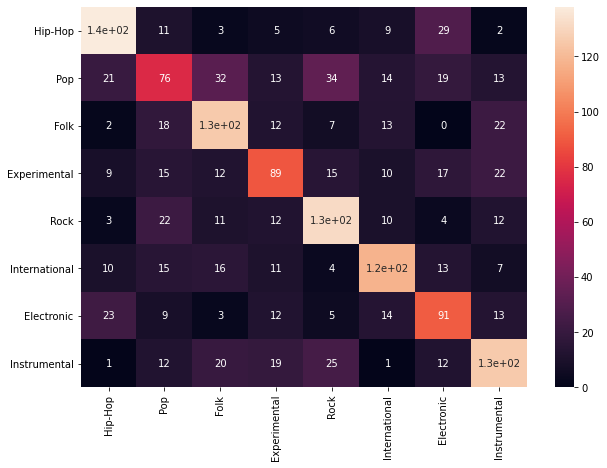

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
confusion_matrix=confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(confusion_matrix, index = [i for i in target_names],
                  columns = [i for i in target_names])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

# CNN 

In [66]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

In [67]:
datafile_cnn = pd.read_csv('datafile - 2.csv')

In [68]:
X = datafile_cnn.drop(['Genre'], axis=1).values
y = datafile_cnn['Genre'].values

In [69]:
print(X.shape)
print(y.shape)

(7997, 134)
(7997,)


In [71]:
no_of_sample = X.shape[0]
X_new = np.zeros((no_of_sample, 140))

In [72]:
X_new[:,0:134] = X

In [73]:
X = X_new

In [74]:
X = X.reshape(-1,14,10,1)

In [75]:
from tensorflow.keras.utils import to_categorical
y_new = to_categorical(y)

In [76]:
print(y_new)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [77]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_new, test_size=0.1, random_state=42)

In [78]:
print(X_train.shape, X_test.shape)

(7197, 14, 10, 1) (800, 14, 10, 1)


In [79]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [80]:
print(X_train.shape, X_val.shape)

(6477, 14, 10, 1) (720, 14, 10, 1)


# CNN Model

In [82]:
from sklearn.metrics import confusion_matrix
import itertools

from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

model = Sequential()
#
model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (14,10,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.20))
#
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.20))
# fully connected
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(8, activation = "softmax"))

In [83]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

In [84]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [87]:
epochs = 2000# for better result increase the epochs
batch_size = 200

In [88]:
# Fit the model
history = model.fit(X_train,y_train, batch_size=batch_size, epochs = epochs, validation_data = (X_val,y_val))

Epoch 1/2000
33/33 [==============================] - 0s 13ms/step - loss: 1.5485 - accuracy: 0.4323 - val_loss: 1.5552 - val_accuracy: 0.4528
Epoch 2/2000
33/33 [==============================] - 0s 10ms/step - loss: 1.5279 - accuracy: 0.4462 - val_loss: 1.5540 - val_accuracy: 0.4444
Epoch 3/2000
33/33 [==============================] - 0s 12ms/step - loss: 1.5140 - accuracy: 0.4487 - val_loss: 1.5519 - val_accuracy: 0.4389
Epoch 4/2000
33/33 [==============================] - 0s 10ms/step - loss: 1.5233 - accuracy: 0.4414 - val_loss: 1.5506 - val_accuracy: 0.4361
Epoch 5/2000
33/33 [==============================] - 0s 10ms/step - loss: 1.5286 - accuracy: 0.4440 - val_loss: 1.5618 - val_accuracy: 0.4500
Epoch 6/2000
33/33 [==============================] - 0s 10ms/step - loss: 1.5292 - accuracy: 0.4414 - val_loss: 1.5449 - val_accuracy: 0.4486
Epoch 7/2000
33/33 [==============================] - 0s 10ms/step - loss: 1.5312 - accuracy: 0.4362 - val_loss: 1.5452 - val_accuracy: 0.4625

33/33 [==============================] - 0s 9ms/step - loss: 1.5309 - accuracy: 0.4411 - val_loss: 1.5315 - val_accuracy: 0.4556
Epoch 59/2000
33/33 [==============================] - 0s 10ms/step - loss: 1.5217 - accuracy: 0.4442 - val_loss: 1.5293 - val_accuracy: 0.4500
Epoch 60/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.5259 - accuracy: 0.4434 - val_loss: 1.5279 - val_accuracy: 0.4542
Epoch 61/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.6467 - accuracy: 0.4382 - val_loss: 1.5535 - val_accuracy: 0.4444
Epoch 62/2000
33/33 [==============================] - 0s 10ms/step - loss: 1.5980 - accuracy: 0.4352 - val_loss: 1.5488 - val_accuracy: 0.4500
Epoch 63/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.5474 - accuracy: 0.4385 - val_loss: 1.5317 - val_accuracy: 0.4528
Epoch 64/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.5427 - accuracy: 0.4352 - val_loss: 1.5579 - val_accuracy: 0.4472
Epoch 65/20

33/33 [==============================] - 0s 9ms/step - loss: 1.5112 - accuracy: 0.4430 - val_loss: 1.5475 - val_accuracy: 0.4278
Epoch 116/2000
33/33 [==============================] - 0s 10ms/step - loss: 1.5223 - accuracy: 0.4417 - val_loss: 1.5366 - val_accuracy: 0.4486
Epoch 117/2000
33/33 [==============================] - 0s 10ms/step - loss: 1.5092 - accuracy: 0.4399 - val_loss: 1.5297 - val_accuracy: 0.4667
Epoch 118/2000
33/33 [==============================] - 0s 10ms/step - loss: 1.5015 - accuracy: 0.4562 - val_loss: 1.5169 - val_accuracy: 0.4472
Epoch 119/2000
33/33 [==============================] - 0s 11ms/step - loss: 1.5092 - accuracy: 0.4511 - val_loss: 1.5474 - val_accuracy: 0.4611
Epoch 120/2000
33/33 [==============================] - 0s 10ms/step - loss: 1.5240 - accuracy: 0.4501 - val_loss: 1.5304 - val_accuracy: 0.4611
Epoch 121/2000
33/33 [==============================] - 0s 10ms/step - loss: 1.5191 - accuracy: 0.4445 - val_loss: 1.5446 - val_accuracy: 0.4556
E

Epoch 228/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.5141 - accuracy: 0.4553 - val_loss: 1.5291 - val_accuracy: 0.4542
Epoch 229/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.4984 - accuracy: 0.4570 - val_loss: 1.5256 - val_accuracy: 0.4528
Epoch 230/2000
33/33 [==============================] - 0s 11ms/step - loss: 1.4995 - accuracy: 0.4587 - val_loss: 1.5126 - val_accuracy: 0.4583
Epoch 231/2000
33/33 [==============================] - 0s 10ms/step - loss: 1.5078 - accuracy: 0.4538 - val_loss: 1.5218 - val_accuracy: 0.4625
Epoch 232/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.4921 - accuracy: 0.4531 - val_loss: 1.5315 - val_accuracy: 0.4653
Epoch 233/2000
33/33 [==============================] - 0s 10ms/step - loss: 1.5088 - accuracy: 0.4518 - val_loss: 1.5174 - val_accuracy: 0.4667
Epoch 234/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.5949 - accuracy: 0.4501 - val_loss: 1.5322 - val_accura

Epoch 285/2000
33/33 [==============================] - 0s 10ms/step - loss: 1.4868 - accuracy: 0.4570 - val_loss: 1.5403 - val_accuracy: 0.4625
Epoch 286/2000
33/33 [==============================] - 0s 10ms/step - loss: 1.5088 - accuracy: 0.4505 - val_loss: 1.5601 - val_accuracy: 0.4514
Epoch 287/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.6114 - accuracy: 0.4494 - val_loss: 1.5411 - val_accuracy: 0.4583
Epoch 288/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.5139 - accuracy: 0.4454 - val_loss: 1.5504 - val_accuracy: 0.4486
Epoch 289/2000
33/33 [==============================] - 0s 10ms/step - loss: 1.5198 - accuracy: 0.4494 - val_loss: 1.5793 - val_accuracy: 0.4514
Epoch 290/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.5284 - accuracy: 0.4379 - val_loss: 1.5455 - val_accuracy: 0.4611
Epoch 291/2000
33/33 [==============================] - 0s 10ms/step - loss: 1.5199 - accuracy: 0.4530 - val_loss: 1.5424 - val_accur

Epoch 398/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.5129 - accuracy: 0.4491 - val_loss: 1.5300 - val_accuracy: 0.4681
Epoch 399/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.4945 - accuracy: 0.4610 - val_loss: 1.5528 - val_accuracy: 0.4500
Epoch 400/2000
33/33 [==============================] - 0s 10ms/step - loss: 1.4863 - accuracy: 0.4669 - val_loss: 1.5227 - val_accuracy: 0.4625
Epoch 401/2000
33/33 [==============================] - 0s 10ms/step - loss: 1.5004 - accuracy: 0.4524 - val_loss: 1.5251 - val_accuracy: 0.4639
Epoch 402/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.5018 - accuracy: 0.4510 - val_loss: 1.5333 - val_accuracy: 0.4681
Epoch 403/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.4883 - accuracy: 0.4535 - val_loss: 1.5388 - val_accuracy: 0.4569
Epoch 404/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.4878 - accuracy: 0.4584 - val_loss: 1.5171 - val_accurac

Epoch 511/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.4817 - accuracy: 0.4644 - val_loss: 1.5313 - val_accuracy: 0.4597
Epoch 512/2000
33/33 [==============================] - 0s 10ms/step - loss: 1.4848 - accuracy: 0.4612 - val_loss: 1.5212 - val_accuracy: 0.4667
Epoch 513/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.4921 - accuracy: 0.4564 - val_loss: 1.5451 - val_accuracy: 0.4556
Epoch 514/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.4890 - accuracy: 0.4568 - val_loss: 1.5313 - val_accuracy: 0.4583
Epoch 515/2000
33/33 [==============================] - 0s 10ms/step - loss: 1.4630 - accuracy: 0.4724 - val_loss: 1.5306 - val_accuracy: 0.4625
Epoch 516/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.4811 - accuracy: 0.4652 - val_loss: 1.5604 - val_accuracy: 0.4292
Epoch 517/2000
33/33 [==============================] - 0s 11ms/step - loss: 1.5063 - accuracy: 0.4541 - val_loss: 1.5354 - val_accura

Epoch 568/2000
33/33 [==============================] - 0s 10ms/step - loss: 1.4899 - accuracy: 0.4587 - val_loss: 1.5472 - val_accuracy: 0.4653
Epoch 569/2000
33/33 [==============================] - 0s 11ms/step - loss: 1.4819 - accuracy: 0.4663 - val_loss: 1.5417 - val_accuracy: 0.4639
Epoch 570/2000
33/33 [==============================] - 0s 10ms/step - loss: 1.4750 - accuracy: 0.4687 - val_loss: 1.5516 - val_accuracy: 0.4403
Epoch 571/2000
33/33 [==============================] - 0s 10ms/step - loss: 1.4794 - accuracy: 0.4592 - val_loss: 1.5325 - val_accuracy: 0.4556
Epoch 572/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.4727 - accuracy: 0.4615 - val_loss: 1.5293 - val_accuracy: 0.4528
Epoch 573/2000
33/33 [==============================] - 0s 10ms/step - loss: 1.4912 - accuracy: 0.4652 - val_loss: 1.5291 - val_accuracy: 0.4542
Epoch 574/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.4795 - accuracy: 0.4575 - val_loss: 1.5207 - val_accu

Epoch 625/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.4982 - accuracy: 0.4590 - val_loss: 1.5328 - val_accuracy: 0.4653
Epoch 626/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.4736 - accuracy: 0.4564 - val_loss: 1.5444 - val_accuracy: 0.4708
Epoch 627/2000
33/33 [==============================] - 0s 10ms/step - loss: 1.4741 - accuracy: 0.4703 - val_loss: 1.5251 - val_accuracy: 0.4597
Epoch 628/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.4786 - accuracy: 0.4638 - val_loss: 1.5298 - val_accuracy: 0.4764
Epoch 629/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.4724 - accuracy: 0.4673 - val_loss: 1.5296 - val_accuracy: 0.4736
Epoch 630/2000
33/33 [==============================] - 0s 10ms/step - loss: 1.4838 - accuracy: 0.4587 - val_loss: 1.5295 - val_accuracy: 0.4611
Epoch 631/2000
33/33 [==============================] - 0s 10ms/step - loss: 1.4827 - accuracy: 0.4601 - val_loss: 1.5417 - val_accura

Epoch 682/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.4823 - accuracy: 0.4711 - val_loss: 1.5289 - val_accuracy: 0.4556
Epoch 683/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.4733 - accuracy: 0.4683 - val_loss: 1.5339 - val_accuracy: 0.4597
Epoch 684/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.4898 - accuracy: 0.4584 - val_loss: 1.5247 - val_accuracy: 0.4694
Epoch 685/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.4758 - accuracy: 0.4643 - val_loss: 1.5175 - val_accuracy: 0.4681
Epoch 686/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.4733 - accuracy: 0.4629 - val_loss: 1.5290 - val_accuracy: 0.4667
Epoch 687/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.4716 - accuracy: 0.4629 - val_loss: 1.5384 - val_accuracy: 0.4792
Epoch 688/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.4883 - accuracy: 0.4587 - val_loss: 1.5456 - val_accuracy:

Epoch 739/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.4656 - accuracy: 0.4714 - val_loss: 1.5317 - val_accuracy: 0.4736
Epoch 740/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.4778 - accuracy: 0.4596 - val_loss: 1.5092 - val_accuracy: 0.4847
Epoch 741/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.4670 - accuracy: 0.4660 - val_loss: 1.5382 - val_accuracy: 0.4611
Epoch 742/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.4583 - accuracy: 0.4673 - val_loss: 1.5135 - val_accuracy: 0.4792
Epoch 743/2000
33/33 [==============================] - 0s 10ms/step - loss: 1.4719 - accuracy: 0.4718 - val_loss: 1.5341 - val_accuracy: 0.4681
Epoch 744/2000
33/33 [==============================] - 0s 11ms/step - loss: 1.4645 - accuracy: 0.4633 - val_loss: 1.5250 - val_accuracy: 0.4569
Epoch 745/2000
33/33 [==============================] - 0s 11ms/step - loss: 1.4819 - accuracy: 0.4629 - val_loss: 1.5326 - val_accura

33/33 [==============================] - 0s 9ms/step - loss: 1.4719 - accuracy: 0.4687 - val_loss: 1.5152 - val_accuracy: 0.4583
Epoch 852/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.4699 - accuracy: 0.4650 - val_loss: 1.5179 - val_accuracy: 0.4694
Epoch 853/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.4883 - accuracy: 0.4570 - val_loss: 1.5349 - val_accuracy: 0.4639
Epoch 854/2000
33/33 [==============================] - 0s 10ms/step - loss: 1.4950 - accuracy: 0.4612 - val_loss: 1.5218 - val_accuracy: 0.4667
Epoch 855/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.4878 - accuracy: 0.4598 - val_loss: 1.5218 - val_accuracy: 0.4736
Epoch 856/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.4920 - accuracy: 0.4619 - val_loss: 1.5214 - val_accuracy: 0.4778
Epoch 857/2000
33/33 [==============================] - 0s 10ms/step - loss: 1.4653 - accuracy: 0.4667 - val_loss: 1.5156 - val_accuracy: 0.4583
Epoch

Epoch 964/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.5429 - accuracy: 0.4619 - val_loss: 1.5071 - val_accuracy: 0.4681
Epoch 965/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.4845 - accuracy: 0.4598 - val_loss: 1.4995 - val_accuracy: 0.4847
Epoch 966/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.4788 - accuracy: 0.4575 - val_loss: 1.5012 - val_accuracy: 0.4833
Epoch 967/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.4892 - accuracy: 0.4592 - val_loss: 1.5071 - val_accuracy: 0.4861
Epoch 968/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.4718 - accuracy: 0.4613 - val_loss: 1.5137 - val_accuracy: 0.4931
Epoch 969/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.4727 - accuracy: 0.4613 - val_loss: 1.4922 - val_accuracy: 0.4819
Epoch 970/2000
33/33 [==============================] - 0s 10ms/step - loss: 1.4758 - accuracy: 0.4609 - val_loss: 1.5006 - val_accuracy

33/33 [==============================] - 0s 9ms/step - loss: 1.4604 - accuracy: 0.4652 - val_loss: 1.5180 - val_accuracy: 0.4681
Epoch 1077/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.4634 - accuracy: 0.4677 - val_loss: 1.5130 - val_accuracy: 0.4653
Epoch 1078/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.5020 - accuracy: 0.4650 - val_loss: 1.5237 - val_accuracy: 0.4500
Epoch 1079/2000
33/33 [==============================] - 0s 10ms/step - loss: 1.4519 - accuracy: 0.4715 - val_loss: 1.5091 - val_accuracy: 0.4611
Epoch 1080/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.4637 - accuracy: 0.4579 - val_loss: 1.5067 - val_accuracy: 0.4708
Epoch 1081/2000
33/33 [==============================] - 0s 10ms/step - loss: 1.4608 - accuracy: 0.4647 - val_loss: 1.4958 - val_accuracy: 0.4819
Epoch 1082/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.4605 - accuracy: 0.4761 - val_loss: 1.5001 - val_accuracy: 0.4750

Epoch 1188/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.4568 - accuracy: 0.4707 - val_loss: 1.5061 - val_accuracy: 0.4764
Epoch 1189/2000
33/33 [==============================] - 0s 10ms/step - loss: 1.4564 - accuracy: 0.4655 - val_loss: 1.4988 - val_accuracy: 0.4653
Epoch 1190/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.4650 - accuracy: 0.4707 - val_loss: 1.5050 - val_accuracy: 0.4694
Epoch 1191/2000
33/33 [==============================] - 0s 9ms/step - loss: 1.4620 - accuracy: 0.4660 - val_loss: 1.4935 - val_accuracy: 0.4681
Epoch 1192/2000
33/33 [==============================] - 0s 10ms/step - loss: 1.5667 - accuracy: 0.4709 - val_loss: 1.5022 - val_accuracy: 0.4750
Epoch 1193/2000
33/33 [==============================] - 0s 10ms/step - loss: 1.4912 - accuracy: 0.4601 - val_loss: 1.5211 - val_accuracy: 0.4625
Epoch 1194/2000
33/33 [==============================] - 5s 151ms/step - loss: 1.4617 - accuracy: 0.4649 - val_loss: 1.5227 - v

33/33 [==============================] - 1s 16ms/step - loss: 1.4890 - accuracy: 0.4678 - val_loss: 1.5413 - val_accuracy: 0.4556
Epoch 1301/2000
33/33 [==============================] - 1s 16ms/step - loss: 1.6624 - accuracy: 0.4016 - val_loss: 1.5783 - val_accuracy: 0.4500
Epoch 1302/2000
33/33 [==============================] - 1s 17ms/step - loss: 1.6063 - accuracy: 0.4184 - val_loss: 1.5630 - val_accuracy: 0.4361
Epoch 1303/2000
33/33 [==============================] - 1s 19ms/step - loss: 1.6149 - accuracy: 0.4266 - val_loss: 1.5427 - val_accuracy: 0.4569
Epoch 1304/2000
33/33 [==============================] - 1s 20ms/step - loss: 1.5420 - accuracy: 0.4423 - val_loss: 1.5220 - val_accuracy: 0.4639
Epoch 1305/2000
33/33 [==============================] - 1s 16ms/step - loss: 1.5159 - accuracy: 0.4541 - val_loss: 1.5275 - val_accuracy: 0.4625
Epoch 1306/2000
33/33 [==============================] - 1s 16ms/step - loss: 1.4899 - accuracy: 0.4572 - val_loss: 1.5182 - val_accuracy: 0

33/33 [==============================] - 1s 16ms/step - loss: 1.4466 - accuracy: 0.4721 - val_loss: 1.5044 - val_accuracy: 0.4778
Epoch 1413/2000
33/33 [==============================] - 1s 20ms/step - loss: 1.4498 - accuracy: 0.4717 - val_loss: 1.5135 - val_accuracy: 0.4708
Epoch 1414/2000
33/33 [==============================] - 1s 19ms/step - loss: 1.4677 - accuracy: 0.4624 - val_loss: 1.5114 - val_accuracy: 0.4778
Epoch 1415/2000
33/33 [==============================] - 1s 17ms/step - loss: 1.4662 - accuracy: 0.4757 - val_loss: 1.4942 - val_accuracy: 0.4847
Epoch 1416/2000
33/33 [==============================] - 1s 16ms/step - loss: 1.4487 - accuracy: 0.4748 - val_loss: 1.4984 - val_accuracy: 0.4889
Epoch 1417/2000
33/33 [==============================] - 1s 16ms/step - loss: 1.4566 - accuracy: 0.4686 - val_loss: 1.4880 - val_accuracy: 0.4875
Epoch 1418/2000
33/33 [==============================] - 1s 19ms/step - loss: 1.4650 - accuracy: 0.4652 - val_loss: 1.5048 - val_accuracy: 0

33/33 [==============================] - 1s 16ms/step - loss: 1.4895 - accuracy: 0.4598 - val_loss: 1.5215 - val_accuracy: 0.4653
Epoch 1525/2000
33/33 [==============================] - 1s 16ms/step - loss: 1.4805 - accuracy: 0.4565 - val_loss: 1.5136 - val_accuracy: 0.4583
Epoch 1526/2000
33/33 [==============================] - 1s 16ms/step - loss: 1.4607 - accuracy: 0.4653 - val_loss: 1.5219 - val_accuracy: 0.4681
Epoch 1527/2000
33/33 [==============================] - 1s 16ms/step - loss: 1.4693 - accuracy: 0.4701 - val_loss: 1.5239 - val_accuracy: 0.4639
Epoch 1528/2000
33/33 [==============================] - 0s 15ms/step - loss: 1.4684 - accuracy: 0.4650 - val_loss: 1.5132 - val_accuracy: 0.4681
Epoch 1529/2000
33/33 [==============================] - 0s 15ms/step - loss: 1.4879 - accuracy: 0.4711 - val_loss: 1.5169 - val_accuracy: 0.4736
Epoch 1530/2000
33/33 [==============================] - 1s 16ms/step - loss: 1.4922 - accuracy: 0.4707 - val_loss: 1.5091 - val_accuracy: 0

33/33 [==============================] - 1s 16ms/step - loss: 1.4580 - accuracy: 0.4663 - val_loss: 1.5220 - val_accuracy: 0.4625
Epoch 1637/2000
33/33 [==============================] - 1s 16ms/step - loss: 1.4622 - accuracy: 0.4732 - val_loss: 1.5026 - val_accuracy: 0.4778
Epoch 1638/2000
33/33 [==============================] - 1s 16ms/step - loss: 1.4638 - accuracy: 0.4669 - val_loss: 1.5137 - val_accuracy: 0.4764
Epoch 1639/2000
33/33 [==============================] - 1s 16ms/step - loss: 1.4596 - accuracy: 0.4720 - val_loss: 1.5082 - val_accuracy: 0.4667
Epoch 1640/2000
33/33 [==============================] - 1s 16ms/step - loss: 1.4564 - accuracy: 0.4748 - val_loss: 1.4975 - val_accuracy: 0.4764
Epoch 1641/2000
33/33 [==============================] - 1s 16ms/step - loss: 1.4612 - accuracy: 0.4694 - val_loss: 1.5164 - val_accuracy: 0.4694
Epoch 1642/2000
33/33 [==============================] - 1s 16ms/step - loss: 1.4759 - accuracy: 0.4610 - val_loss: 1.4904 - val_accuracy: 0

33/33 [==============================] - 1s 16ms/step - loss: 1.4439 - accuracy: 0.4771 - val_loss: 1.4867 - val_accuracy: 0.4819
Epoch 1749/2000
33/33 [==============================] - 1s 16ms/step - loss: 1.4540 - accuracy: 0.4639 - val_loss: 1.4889 - val_accuracy: 0.4833
Epoch 1750/2000
33/33 [==============================] - 1s 16ms/step - loss: 1.4545 - accuracy: 0.4658 - val_loss: 1.5113 - val_accuracy: 0.4542
Epoch 1751/2000
33/33 [==============================] - 1s 15ms/step - loss: 1.4431 - accuracy: 0.4786 - val_loss: 1.4800 - val_accuracy: 0.4819
Epoch 1752/2000
33/33 [==============================] - 1s 17ms/step - loss: 1.4468 - accuracy: 0.4741 - val_loss: 1.4949 - val_accuracy: 0.4764
Epoch 1753/2000
33/33 [==============================] - 1s 16ms/step - loss: 1.4481 - accuracy: 0.4748 - val_loss: 1.4879 - val_accuracy: 0.4722
Epoch 1754/2000
33/33 [==============================] - 1s 15ms/step - loss: 1.4444 - accuracy: 0.4638 - val_loss: 1.5006 - val_accuracy: 0

33/33 [==============================] - 1s 16ms/step - loss: 1.4399 - accuracy: 0.4791 - val_loss: 1.4755 - val_accuracy: 0.4694
Epoch 1861/2000
33/33 [==============================] - 0s 15ms/step - loss: 1.4521 - accuracy: 0.4712 - val_loss: 1.5110 - val_accuracy: 0.4625
Epoch 1862/2000
33/33 [==============================] - 1s 16ms/step - loss: 1.4425 - accuracy: 0.4806 - val_loss: 1.5035 - val_accuracy: 0.4708
Epoch 1863/2000
33/33 [==============================] - 1s 16ms/step - loss: 1.4445 - accuracy: 0.4782 - val_loss: 1.4990 - val_accuracy: 0.4764
Epoch 1864/2000
33/33 [==============================] - 1s 16ms/step - loss: 1.4286 - accuracy: 0.4780 - val_loss: 1.5015 - val_accuracy: 0.4750
Epoch 1865/2000
33/33 [==============================] - 1s 17ms/step - loss: 1.4258 - accuracy: 0.4851 - val_loss: 1.4891 - val_accuracy: 0.4611
Epoch 1866/2000
33/33 [==============================] - 1s 16ms/step - loss: 1.4283 - accuracy: 0.4797 - val_loss: 1.5006 - val_accuracy: 0

33/33 [==============================] - 1s 15ms/step - loss: 1.4490 - accuracy: 0.4741 - val_loss: 1.4762 - val_accuracy: 0.4792
Epoch 1973/2000
33/33 [==============================] - 1s 16ms/step - loss: 1.4520 - accuracy: 0.4785 - val_loss: 1.5084 - val_accuracy: 0.4556
Epoch 1974/2000
33/33 [==============================] - 1s 17ms/step - loss: 1.4462 - accuracy: 0.4698 - val_loss: 1.5060 - val_accuracy: 0.4569
Epoch 1975/2000
33/33 [==============================] - 1s 16ms/step - loss: 1.4431 - accuracy: 0.4775 - val_loss: 1.5027 - val_accuracy: 0.4708
Epoch 1976/2000
33/33 [==============================] - 1s 18ms/step - loss: 1.4425 - accuracy: 0.4684 - val_loss: 1.5064 - val_accuracy: 0.4597
Epoch 1977/2000
33/33 [==============================] - 1s 16ms/step - loss: 1.4475 - accuracy: 0.4791 - val_loss: 1.4912 - val_accuracy: 0.4750
Epoch 1978/2000
33/33 [==============================] - 1s 17ms/step - loss: 1.4239 - accuracy: 0.4842 - val_loss: 1.4890 - val_accuracy: 0

In [89]:
# Evaluate the restored model
loss, acc = model.evaluate(X_test,  y_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

25/25 - 1s - loss: 1.5097 - accuracy: 0.4688
Restored model, accuracy: 46.88%
